# Walkthrough Challenge 2 - Generate images with DALL-E 3 and interact with images with GPT-4 Vision

Duration: 45 minutes

## Overview
- In this challenge, you will learn how to generate images with DALL-E 3, a generative model that generates images from text descriptions. We will also combine this model with embedding and text generation models.
- You will also learn how to chat with images with GPT-4 Vision, a large multimodal model that can analyze images and provide textual responses to questions about the them.

## Prerequisites

- Please ensure that you have completed the [Setup](../setup/setup.ipynb) before starting this challenge.

### Task 1: Configure and Initialize Semantic Kernel

⚠️ Note: You should have already completed all tasks on the [Setup](../setup/setup.ipynb). If you have not, please go back and complete it now.

#### Step 1: Load Semantic Kernel settings

In this step, we will load the Semantic Kernel settings that we created in the [Setup](../setup/setup.ipynb) notebook.

In [56]:
#r "nuget: Microsoft.SemanticKernel, 1.0.1"
#r "nuget: System.Numerics.Tensors, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"
#r "nuget: SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3"

#!import ../setup/config/Settings.cs
#!import ../setup/config/Utils.cs
#!import ../setup/config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using System.Numerics.Tensors;

Installed Packages Microsoft.SemanticKernel, 1.0.1 SkiaSharp, 2.88.3 SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3 System.Numerics.Tensors, 8.0.0

#### Step 2: Initialize Semantic Kernel

This challenge uses `dall-e-3` and `gpt4-vision` models. We will initialize the Semantic Kernel with these models.

If you are using Azure OpenAI Service, make sure that you have these models deployed in your workspace. At the time of writing, these particular models are only available in a restrict number of Azure Regions. Please refer to [Azure OpenAI Service models](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) documentation for more information.

In [3]:
using Kernel = Microsoft.SemanticKernel.Kernel;

#pragma warning disable SKEXP0001, SKEXP0002, SKEXP0011, SKEXP0012

// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile("../setup/config/settings.json");

// Configure the three AI features: text embedding (using Ada), chat completion, image generation (DALL-E 3)
var builder = Kernel.CreateBuilder();

if(useAzureOpenAI)
{
    builder.AddAzureOpenAITextEmbeddingGeneration("text-embedding-ada-002", azureEndpoint, apiKey);
    builder.AddAzureOpenAIChatCompletion("gpt-4-vision", azureEndpoint, apiKey);
    builder.AddAzureOpenAITextToImage("Dalle3", azureEndpoint, apiKey);
}
else
{
    builder.AddOpenAITextEmbeddingGeneration("text-embedding-ada-002", apiKey, orgId);
    builder.AddOpenAIChatCompletion("gpt-4-vision", apiKey, orgId);
    builder.AddOpenAITextToImage(apiKey, orgId);
}

var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

// Get AI service instance used to extract embedding from a text
var textEmbedding = kernel.GetRequiredService<ITextEmbeddingGenerationService>();

### Task 2: Create a Image Generation Semantic Function

Let's initialize some content that will be used to create the description for the image that we want to generate. In this example, we will use an excerpt from [Wikipedia](https://en.wikipedia.org/wiki/Colossus_of_Rhodes) about the Colossus of Rhodes, one of the Seven Wonders of the Ancient World.

In [24]:
var input = """
The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized: ho Kolossòs Rhódios; Greek: Κολοσσός της Ρόδου, romanized: Kolossós tes Rhódou)[a] was a statue of the Greek sun god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280 BC.
One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius I of Macedon, who had besieged it for a year with a large army and navy.
According to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved.
In accordance with a certain oracle, the Rhodians did not rebuild it.[3] John Malalas wrote that Hadrian in his reign re-erected the Colossus,[4] but he was mistaken.[5] According to the Suda, the Rhodians were called Colossaeans (Κολοσσαεῖς), because they erected the statue on the island.[6]
""";

We can now create a Semantic Function that will generate a image description from the content that we have initialized.

In [25]:
string prompt = """
{{$input}}

Make a short description of the text above.
It should be a visual description of the text, that will be used to generate an image.
""";

// Create ExecutionSettings for the prompt
var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 1
};

// Create a semantic function that generate a random image description.
var imgDescriptionFunction = kernel.CreateFunctionFromPrompt(prompt, executionSettings);

Let's execute the Semantic Function to generate the image description. After the image description is generated, we will ask DALL-E 3 to generate an image from the description.


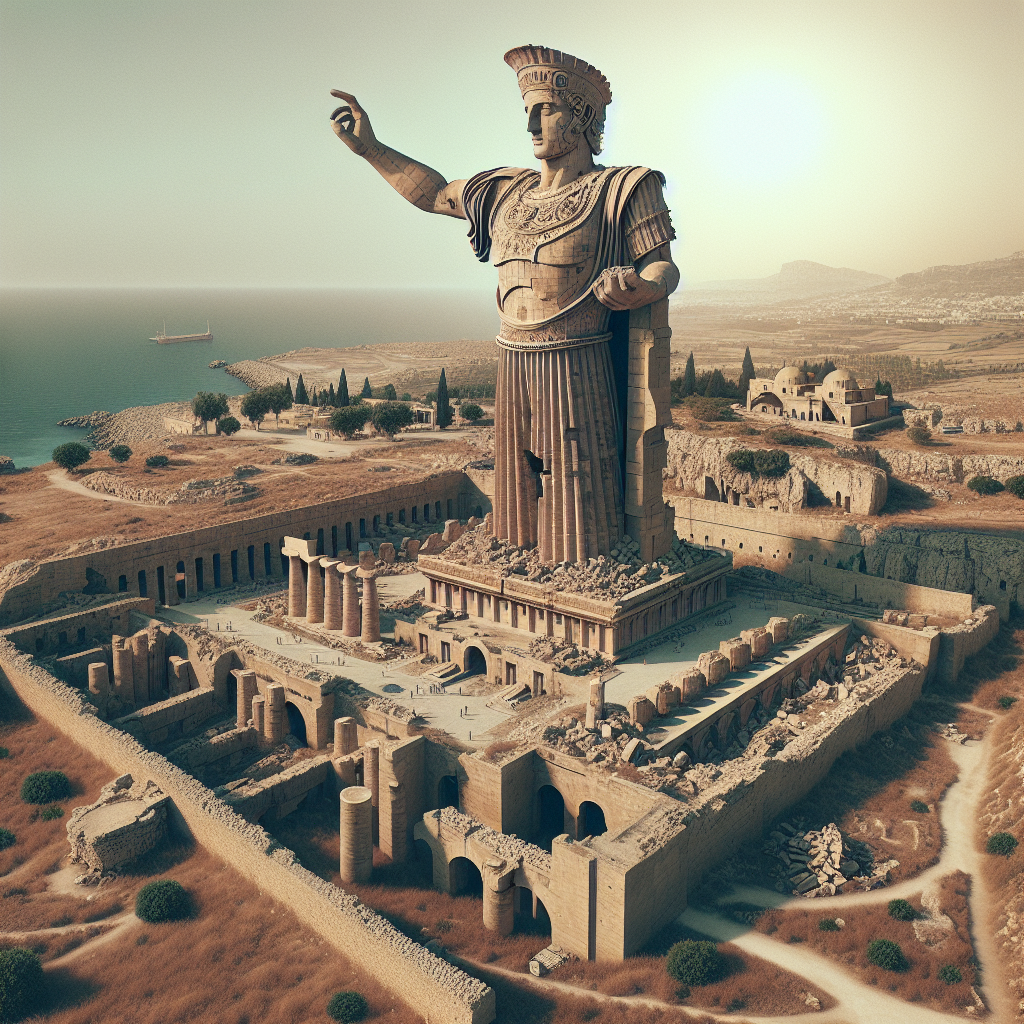

Image generated from text: A towering statue of the Greek sun god Helios stands majestically in the ancient city of Rhodes, reaching a height of 33 meters (108 feet), akin to the modern Statue of Liberty. Its grandeur marks a celebration of military victory. However, the structure lies in ruins, with only remnants left after a devastating earthquake in 226 BC. The landscape implies a historical Mediterranean setting.


In [37]:
#pragma warning disable SKEXP0002

var imageDescriptionResult = await kernel.InvokeAsync(imgDescriptionFunction, new() { ["input"] = input });
var imageDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);

Console.WriteLine("Image generated from text: " + imageDescription);

You can experiment with different content and see how the generated image changes. For example, try changing the content to a description of [Machu Picchu](https://en.wikipedia.org/wiki/Machu_Picchu) in Peru, one of the New Seven Wonders of the World. Or even a biography of your favorite celebrity!


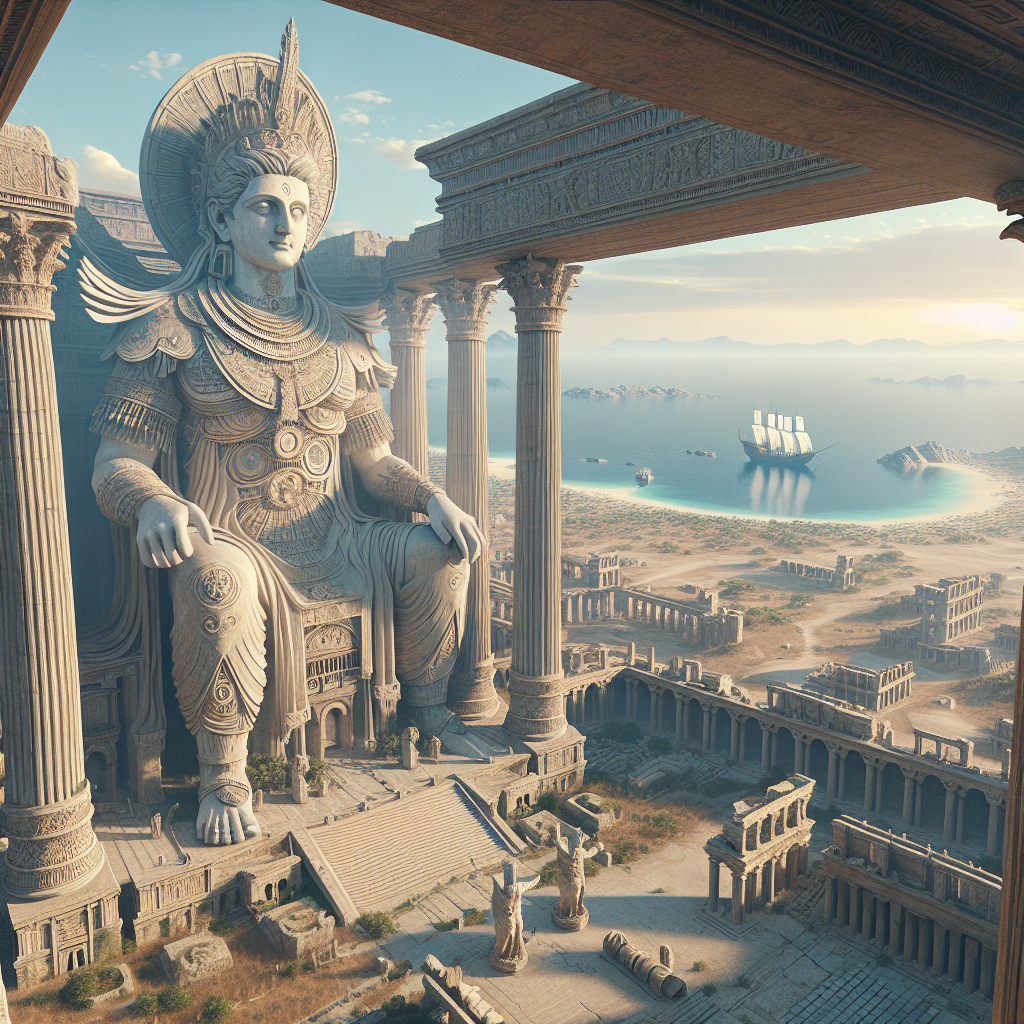

Image generated from text: A massive statue stands regally over an ancient complex, with classical columns and ruins suggesting its past cultural significance. The statue, possibly representing a deity or ruler, is richly adorned and set against a backdrop of arid landscapes and a calm sea coastline. A solitary ship sails in the distance, near a settlement with domed buildings, under a serene, clear sky illuminating the scene with warm light.


In [46]:
var content = """
Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru on a 2,430-meter (7,970 ft) mountain ridge.[2][3] Often referred to as the "Lost City of the Incas", it is the most familiar icon of the Inca Empire. It is located in the Machupicchu District within Urubamba Province[4] above the Sacred Valley, which is 80 kilometers (50 mi) northwest of Cusco. The Urubamba River flows past it, cutting through the Cordillera and creating a canyon with a tropical mountain climate.[5] In reference to the site's name, for most English or Spanish speakers, the first 'c' in Picchu is silent. In English, the name is pronounced /ˌmɑːtʃuː ˈpiːtʃuː/ MAH-choo PEE-choo[6][7] or /ˌmætʃuː ˈpiːktʃuː/ MATCH-oo PEAK-choo,[7][8] in Spanish as [ˈmatʃu ˈpitʃu] or [ˈmatʃu ˈpiɣtʃu],[9] and in Quechua (Machu Pikchu)[10] as [ˈmatʃʊ ˈpɪktʃʊ].
""";

#pragma warning disable SKEXP0002

var imageDescriptionResult = await kernel.InvokeAsync(imgDescriptionFunction, new() { ["input"] = content });
var imageDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);

Console.WriteLine("Image generated from text: " + imageDescription);

### Task 3: Use GPT-4 Vision to Interact with Images

GPT-4 Vision is a large multimodal model that can analyze images and provide textual responses to questions about the them. In this example, we will use GPT-4 Vision to analyze the image that we generated in the previous task.

In [43]:
var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

var chatHistory = new ChatHistory("You are trained to interpret images and make responsible assumptions about them.");

chatHistory.AddUserMessage(new ChatMessageContentItemCollection
{
    new TextContent("Give me a description of this image:"),
    new ImageContent(new Uri(imageUrl))
});

var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 0.2
};

var reply = await chatCompletionService.GetChatMessageContentAsync(chatHistory, executionSettings);

Console.WriteLine(reply.Content);

The image depicts a colossal statue towering over an ancient architectural complex, reminiscent of a historical or mythological setting. The statue is adorned with intricate clothing and accessories, suggesting a figure of great importance, possibly a deity or a ruler. It stands on a pedestal that is part of a larger complex with classical columns, ruins, and courtyards, indicating a place of significant cultural or religious activity in the past.

Surrounding the structure are arid landscapes with sparse vegetation, leading to a coastline with a calm sea. In the distance, a solitary ship can be seen sailing near the shore. The terrain gradually rises to rolling hills, and a settlement with buildings and domes is visible, suggesting a nearby community or city. The overall atmosphere is serene, with a clear sky casting a warm light on the scene, evoking a sense of historical grandeur and timelessness.



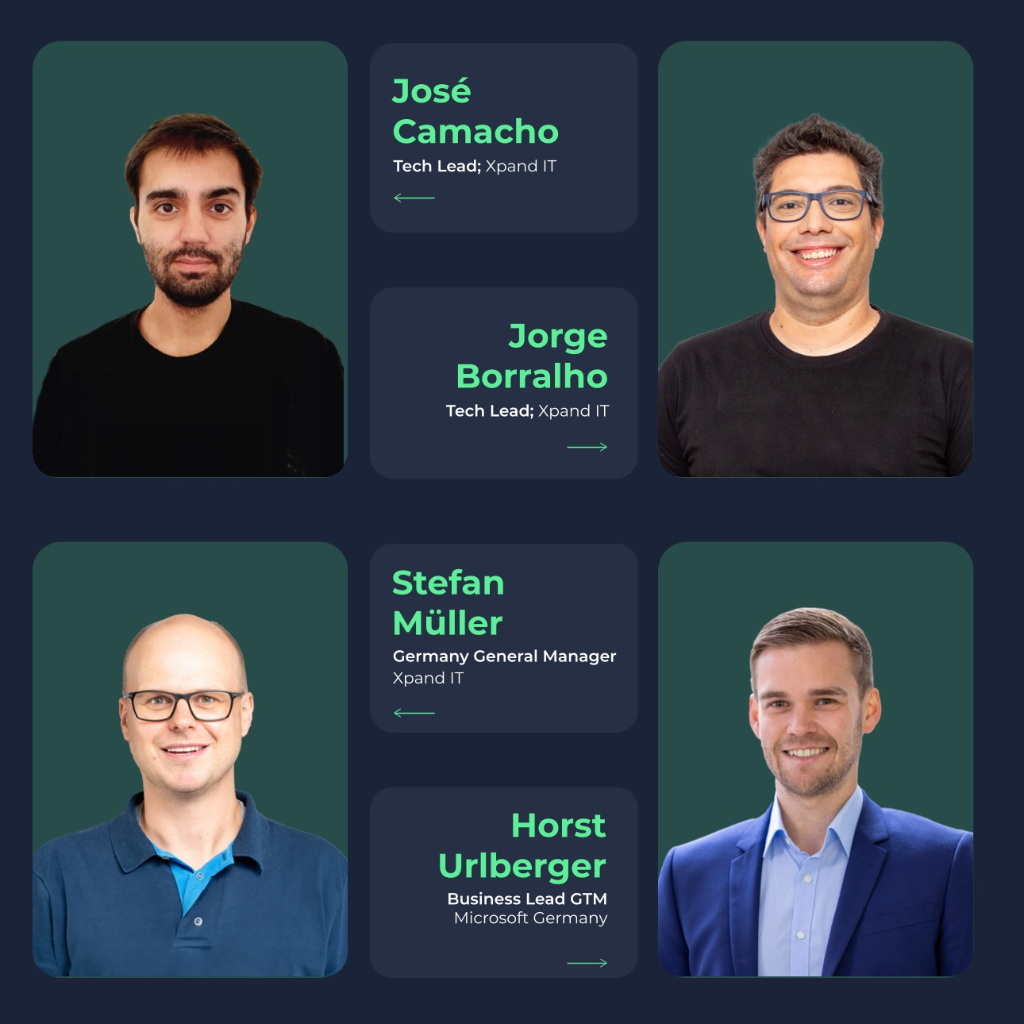

In [61]:
const string ImageUri = "https://media.licdn.com/dms/image/D4D1FAQFTEXiTqfELaw/feedshare-document-images_1280/2/1706096961111?e=1707350400&v=beta&t=jNxHoHCBw4KFwbIurcqIdRcKKQ9P--l_UEDEn6jinbI";

// Show the above image
await SkiaUtils.ShowImage(ImageUri, 1024, 1024);

In [62]:

var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

var chatHistory = new ChatHistory("You are trained to interpret images about people and make responsible assumptions about them.");

chatHistory.AddUserMessage(new ChatMessageContentItemCollection
{
    new TextContent("Give me a json with the names, roles and company of the people in the image"),
    new ImageContent(new Uri(ImageUri))
});

var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 0.2
};

var reply = await chatCompletionService.GetChatMessageContentAsync(chatHistory, executionSettings);

Console.WriteLine(reply.Content);

```json
[
  {
    "name": "José Camacho",
    "role": "Tech Lead",
    "company": "Xpand IT"
  },
  {
    "name": "Jorge Borralho",
    "role": "Tech Lead",
    "company": "Xpand IT"
  },
  {
    "name": "Stefan Müller",
    "role": "Germany General Manager",
    "company": "Xpand IT"
  },
  {
    "name": "Horst Urlberger",
    "role": "Business Lead GTM",
    "company": "Microsoft Germany"
  }
]
```
